In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
transform = transforms.ToTensor()

In [3]:
train_data = datasets.MNIST(root='../Data', train=True, download=True, transform=transform)

In [4]:
test_data = datasets.MNIST(root='../Data', train=False, download=True, transform=transform)

In [5]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ../Data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [6]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: ../Data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [7]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [8]:
# 1 COLOR Channel, 6 Filters (Output Channels), 3b3 kernel, STRIDE=1
conv1 = nn.Conv2d(1, 6, 3, 1) # ---> 6 filters ---> pooling ---> conv2

# 6 Input Filturs Conv1, 16 filters, 3by3, stride=1
conv2 = nn.Conv2d(6, 16, 3, 1) 


In [29]:
for i, (X_train, y_train) in enumerate(train_data):
    break

In [30]:
X_train.shape

torch.Size([1, 28, 28])

In [12]:
x = X_train.view(1, 1, 28, 28) # ---> 4D batch of 1 image

In [13]:
x = F.relu(conv1(x))

In [15]:
x.shape

torch.Size([1, 6, 26, 26])

In [16]:
x = F.max_pool2d(x,2,2)

In [17]:
x.shape

torch.Size([1, 6, 13, 13])

In [20]:
x = F.relu(conv2(x))

In [21]:
x.shape

torch.Size([1, 16, 11, 11])

In [22]:
x = F.max_pool2d(x, 2, 2)
x.shape

torch.Size([1, 16, 5, 5])

In [23]:
x.view(-1,16*5*5).shape

torch.Size([1, 400])

In [25]:
class ConvolutionalNetwork(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 16*5*5)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)
        

In [26]:
torch.manual_seed(42)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [27]:
for param in model.parameters():
    print(param.numel())

54
6
864
16
48000
120
10080
84
840
10


In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [31]:
import time
start_time = time.time()

# Variables (Trackers)
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# For Loop Epochs
for i in range(epochs):
    
    trn_corr = 0
    tst_corr = 0
    
    # Train
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        y_pred = model(X_train) # Not Flatten!
        loss = criterion(y_pred, y_train)
        
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum() # True 1/ False 0 sum()
        trn_corr += batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%600 == 0:
            print(f"EPOCH: {i} BATCH: {b} LOSS: {loss.item()}")
            
    train_losses.append(loss)
    train_correct.append(trn_corr)
    
    # Test
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            
            y_val = model(X_test)
            
            predicted = torch.max(y_val, 1)[1]
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

current_time = time.time()
total = current_time - start_time
print(f"Trainig took {total/60} minutes")


EPOCH: 0 BATCH: 600 LOSS: 0.21157124638557434
EPOCH: 0 BATCH: 1200 LOSS: 0.579678475856781
EPOCH: 0 BATCH: 1800 LOSS: 0.05560563877224922
EPOCH: 0 BATCH: 2400 LOSS: 0.0341942124068737
EPOCH: 0 BATCH: 3000 LOSS: 0.010335903614759445
EPOCH: 0 BATCH: 3600 LOSS: 0.005747481714934111
EPOCH: 0 BATCH: 4200 LOSS: 0.053997285664081573
EPOCH: 0 BATCH: 4800 LOSS: 0.0029320730827748775
EPOCH: 0 BATCH: 5400 LOSS: 0.00047731475206092
EPOCH: 0 BATCH: 6000 LOSS: 0.005763170309364796
EPOCH: 1 BATCH: 600 LOSS: 0.03618915006518364
EPOCH: 1 BATCH: 1200 LOSS: 0.331460565328598
EPOCH: 1 BATCH: 1800 LOSS: 0.22193005681037903
EPOCH: 1 BATCH: 2400 LOSS: 0.00852859579026699
EPOCH: 1 BATCH: 3000 LOSS: 0.0009925472550094128
EPOCH: 1 BATCH: 3600 LOSS: 0.1520923674106598
EPOCH: 1 BATCH: 4200 LOSS: 0.019688805565238
EPOCH: 1 BATCH: 4800 LOSS: 0.2398243397474289
EPOCH: 1 BATCH: 5400 LOSS: 0.014966572634875774
EPOCH: 1 BATCH: 6000 LOSS: 0.009659006260335445
EPOCH: 2 BATCH: 600 LOSS: 0.0018652541330084205
EPOCH: 2 BATC

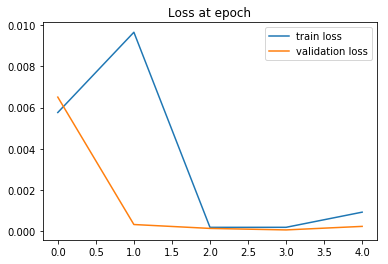

In [33]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='validation loss')
plt.title("Loss at epoch")
plt.legend()

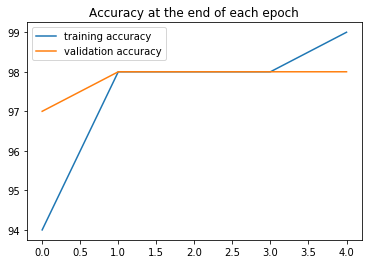

In [34]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [35]:
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [36]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val, 1)[1]
        correct += (predicted == y_test).sum()

In [37]:
correct.item() / 10000

0.9848

In [38]:
# print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# print the confusion matrix
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 978    0    3    2    0    2    5    1   12    2]
 [   0 1130    8    1    0    0    2    2    0    0]
 [   0    0 1011    2    0    0    1    3    2    0]
 [   0    1    1  998    0    8    0    0    2    3]
 [   0    0    2    0  975    0    3    0    0    4]
 [   0    0    0    4    0  870    1    0    1    2]
 [   1    1    0    0    2    6  945    0    3    1]
 [   0    1    6    1    0    1    0 1004    3    3]
 [   0    2    1    2    1    0    1    0  946    3]
 [   1    0    0    0    4    5    0   18    5  991]]


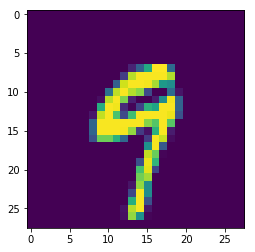

In [39]:
plt.imshow(test_data[2019][0].reshape(28,28))

In [40]:
model.eval()
with torch.no_grad():
    new_prediction = model(test_data[2019][0].view(1,1,28,28))
    

In [41]:
new_prediction

tensor([[-1.8887e+01, -1.8347e+01, -2.0213e+01, -1.7652e+01, -7.4751e+00,
         -1.6691e+01, -2.0895e+01, -1.3297e+01, -1.2985e+01, -5.7125e-04]])

In [42]:
new_prediction.argmax()

tensor(9)